In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Cargar los datos de generación y meteorológicos
plant_1_generation = pd.read_csv('Plant_1_Generation_Data.csv')
plant_1_weather = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')

# Copiar los datos de generación para mantener df_GD1 limpio
df_GD1 = plant_1_generation.copy()

# Aplicar el mapeo a los nombres de los paneles solares
unique_source_keys_list = df_GD1['SOURCE_KEY'].unique()
source_key_mapping = {key: f"Solar_Panel_{i+1}" for i, key in enumerate(unique_source_keys_list)}
df_GD1['SOURCE_KEY'] = df_GD1['SOURCE_KEY'].map(source_key_mapping)

# Convertir la columna 'DATE_TIME' a formato de fecha y hora
df_GD1['DATE_TIME'] = pd.to_datetime(df_GD1['DATE_TIME'], format='%d-%m-%Y %H:%M')
plant_1_weather['DATE_TIME'] = pd.to_datetime(plant_1_weather['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

# Unir los datos meteorológicos al dataframe de generación en función de la fecha y hora
df_GD1_with_weather = pd.merge(df_GD1, plant_1_weather, on='DATE_TIME', how='left')

# Mostrar las primeras filas para verificar la unión
df_GD1_with_weather.head()


,DATE_TIME,PLANT_ID_x,SOURCE_KEY_x,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,PLANT_ID_y,SOURCE_KEY_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15,4135001,Solar_Panel_1,0.0,0.0,0.0,6259559.0,4135001.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15,4135001,Solar_Panel_2,0.0,0.0,0.0,6183645.0,4135001.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
2,2020-05-15,4135001,Solar_Panel_3,0.0,0.0,0.0,6987759.0,4135001.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
3,2020-05-15,4135001,Solar_Panel_4,0.0,0.0,0.0,7602960.0,4135001.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
4,2020-05-15,4135001,Solar_Panel_5,0.0,0.0,0.0,7158964.0,4135001.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0


In [3]:
# Eliminar las columnas PLANT_ID_y y SOURCE_KEY_y y renombrar las columnas PLANT_ID_x y SOURCE_KEY_x
df_GD1_with_weather_clean = df_GD1_with_weather.drop(columns=['PLANT_ID_y', 'SOURCE_KEY_y','PLANT_ID_x'])

# Renombrar las columnas para eliminar el sufijo '_x'
df_GD1_with_weather_clean = df_GD1_with_weather_clean.rename(columns={'SOURCE_KEY_x': 'SOURCE_KEY'})

df_GD1_with_weather_clean.head()


,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15,Solar_Panel_1,0.0,0.0,0.0,6259559.0,25.184316,22.857507,0.0
1,2020-05-15,Solar_Panel_2,0.0,0.0,0.0,6183645.0,25.184316,22.857507,0.0
2,2020-05-15,Solar_Panel_3,0.0,0.0,0.0,6987759.0,25.184316,22.857507,0.0
3,2020-05-15,Solar_Panel_4,0.0,0.0,0.0,7602960.0,25.184316,22.857507,0.0
4,2020-05-15,Solar_Panel_5,0.0,0.0,0.0,7158964.0,25.184316,22.857507,0.0


In [5]:
# Verificar si hay valores nulos
nulos = df_GD1_with_weather_clean.isnull().sum()

# Mostrar cuántos valores nulos hay por columna
print(nulos)

# Rellenar los valores nulos en solo las columnas numéricas con la media
numerical_cols = df_GD1_with_weather_clean.select_dtypes(include=['float64', 'int64']).columns #Estp para quitar los floats
df_GD1_with_weather_clean[numerical_cols] = df_GD1_with_weather_clean[numerical_cols].fillna(df_GD1_with_weather_clean[numerical_cols].mean())

# Mostrar las primeras filas después de limpiar los nulos
df_GD1_with_weather_clean.head()

df_GD1_limpio = df_GD1_with_weather_clean;


DATE_TIME              0
SOURCE_KEY             0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64


In [ ]:
features = ['AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD','AMBIENT_TEMPERATURE', 
            'MODULE_TEMPERATURE', 'IRRADIATION']
# Definir X (variables predictoras) y Y (variable objetivo)
X = df_GD1_limpio[features]
Y = df_GD1_limpio['DC_POWER']

# Dividir los datos en conjunto de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Normalizar las características (X) usando MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear el modelo de regresión lineal
model = LinearRegression()

# Entrenar el modelo con los datos normalizados
model.fit(X_train_scaled, Y_train)

# Hacer predicciones con el conjunto de prueba
Y_pred = model.predict(X_test_scaled)

# Evaluar el modelo con el MSE (Mean Squared Error)
mse = mean_squared_error(Y_test, Y_pred)
print(f"Error Cuadrático Medio (MSE): {mse}")

# Coeficientes del modelo
print("Coeficientes del modelo:", model.coef_)



Error Cuadrático Medio (MSE): 174.3629889280183
Coeficientes del modelo: [ 1.44092901e+04  4.53196859e+00  8.74380261e-02  8.01616096e-01
 -4.32499644e+01  7.88357169e+01]


___
# Random Forest

In [ ]:
RF_model = RandomForestRegressor(n_estimators=350, random_state=42)

RF_model.fit(X_train_scaled,Y_train)

RF_y_pred = RF_model.predict(X_test_scaled)

RF_mse = mean_squared_error(Y_test,RF_y_pred)
RF_r2 = r2_score(Y_test,RF_y_pred)
RF_mae = mean_absolute_error(Y_test,RF_y_pred)
#RF_mape = mean_absolute_percentage_error(Y_test,RF_y_pred)

print(f'Random Forest - Error Cuadrático Medio (MSE): {RF_mse:.3f}')
print(f'Random Forest - Coeficiente de determinación (R^2):{RF_r2:.2f}')
print(f'Random Forest - Error Absoluto Medio (MAE): {RF_mae:.3f}')

Random Forest - Error Cuadrático Medio (MSE): 96.703
Random Forest - Coeficiente de determinación (R^2):1.00
Random Forest - Error Absoluto Medio (MAE): 1.354


## Resultado del modelo Random Forest

Random Forest - Error Cuadrático Medio (MSE): 96.70265742067654

Random Forest - Coeficiente de determinación (R^2):0.9999940139142317

Random Forest - Error Absoluto Medio (MAE): 1.3542036240045914

___
# Validación cruzada

In [7]:
from sklearn.model_selection import cross_val_score

CV_model = cross_val_score(RF_model, X_train_scaled, Y_train, cv=10, scoring='r2')

print(f"Cross-Validation R² scores: {CV_model}")
print(f"R² medio en validación cruzada: {CV_model.mean()}")

Cross-Validation R² scores: [0.99999922 0.99999955 0.99999896 0.9999992  0.99999904 0.99999958
 0.99999957 0.99999949 0.9999987  0.99999925]
R² medio en validación cruzada: 0.9999992555155119


## Resultados de la Validacion Cruzada

Cross-Validation R² scores: [0.99999922 0.99999955 0.99999896 0.9999992  0.99999904 0.99999958 0.99999957 0.99999949 0.9999987  0.99999925]

R² medio en validación cruzada: 0.9999992555155119

____

# Entrenamiento

In [32]:
features = ['AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD','AMBIENT_TEMPERATURE', 
            'MODULE_TEMPERATURE', 'IRRADIATION']
# Definir X (variables predictoras) y Y (variable objetivo)
X = df_GD1_limpio[features]
Y = df_GD1_limpio['DC_POWER']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

In [34]:
model_1 = AdaBoostRegressor()
model_2 = BaggingRegressor()
model_3 = CatBoostRegressor(verbose=0)
model_4 = DecisionTreeRegressor()
model_5 = ElasticNet()
model_6 = ExtraTreesRegressor()
model_7 = KNeighborsRegressor()
model_8 = Lasso()
model_9 = LGBMRegressor(verbose=0)
model_10 = LinearRegression()
model_11 = RandomForestRegressor()
model_12 = Ridge()
model_13 = SVR()
model_14 = XGBRegressor(verbose=0)
model_15 = SGDRegressor()

In [35]:
model_1.fit(X_train, y_train)

AdaBoostRegressor()

In [36]:
model_2.fit(X_train, y_train)   

BaggingRegressor()

In [37]:
model_3.fit(X_train, y_train)

In [38]:
model_4.fit(X_train, y_train)   

DecisionTreeRegressor()

In [39]:
model_5.fit(X_train, y_train)  

ElasticNet()

In [40]:
model_6.fit(X_train, y_train)

ExtraTreesRegressor()

In [41]:
model_7.fit(X_train, y_train)

KNeighborsRegressor()

In [42]:
model_8.fit(X_train, y_train)

Lasso()

In [43]:
model_9.fit(X_train, y_train)

LGBMRegressor(verbose=0)

In [44]:
model_10.fit(X_train, y_train)

LinearRegression()

In [45]:
model_11.fit(X_train, y_train)

RandomForestRegressor()

In [46]:
model_12.fit(X_train, y_train)

Ridge()

In [47]:
model_13.fit(X_train, y_train)

SVR()

In [48]:
model_14.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:12:39] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [49]:
model_15.fit(X_train, y_train)

SGDRegressor()

In [50]:
# List of models:
models = [model_1, model_2, model_3, model_4, model_5,
          model_6, model_7, model_8, model_9, model_10,
          model_11, model_12, model_13, model_14, model_15] #  # 
models_names = ['AdaBoostRegressor', 
                'BaggingRegressor', 
                'CatBoostRegressor', 
                'DecisionTreeRegressor', 
                'ElasticNet', 
                'ExtraTreesRegressor', 
                'KNeighborsRegressor', 
                'LGBMRegressor', 
                'Lasso', 
                'LinearRegression', 
                'RandomForestRegressor', 
                'Ridge', 
                'SVR', 
                'XGBRegressor',
                'SGDRegressor'] #

# Calculate predictions and squared errors for each model:
squared_errors = []
for model in models:
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    squared_errors.append(f'{mse:.2f}')  

# Calculate train and test scores:
train_score = [model.score(X_train, y_train) for model in models]
test_score = [model.score(X_test, y_test) for model in models]
r2_scores = [r2_score(y_test, model.predict(X_test)) for model in models] 

# Difference between training and testing ratio
ratio = []
for train, test in zip(train_score, test_score):
    result = train - test
    ratio.append(f'{result * 100:.2f}%')

# Measure model state:6
rate = []
for train, test in zip(train_score, test_score):
    if train <= 0.65 and test <= 0.65:
        rate.append('bad')
    elif train > test * 1.10:
        rate.append('overfite')
    elif train > 0.65 and train < 0.80 and test > 0.65 and test < 0.80:
        rate.append('middle')
    elif train >= 0.80 and test >= 0.80 and train < 1.00 and test < 1.00:
        rate.append('good')
    elif train >= 0.80 and test < 0.80:
        rate.append('high train, low test')
    else:
        rate.append('unknown')

# Create DataFrame
model_score = pd.DataFrame({
    'Modelo': models_names,
    'Train score': [f'{round(score * 100, 2)}%' for score in train_score],
    'Test score': [f'{round(score * 100, 2)}%' for score in test_score],
    'R² score': [f'{round(r2, 2)}' for r2 in r2_scores],
    'Ratio difference': ratio,
    'Evaluate model': rate,
    'Squared error': squared_errors
})

# Filtrar modelos cuyo `Train score` sea menor o igual a 105%
model_score = model_score[model_score['Train score'].apply(lambda x: 0 <= float(x.strip('%')) <= 105)]

# Show result:
model_score

,Modelo,Train score,Test score,R² score,Ratio difference,Evaluate model,Squared error
0,AdaBoostRegressor,99.76%,99.75%,1.0,0.00%,good,39739.50
1,BaggingRegressor,100.0%,100.0%,1.0,0.00%,good,139.44
2,CatBoostRegressor,100.0%,100.0%,1.0,0.00%,good,484.22
3,DecisionTreeRegressor,100.0%,100.0%,1.0,0.00%,unknown,143.74
4,ElasticNet,100.0%,100.0%,1.0,0.00%,good,220.38
5,ExtraTreesRegressor,100.0%,100.0%,1.0,0.00%,good,145.04
6,KNeighborsRegressor,96.18%,93.3%,0.93,2.88%,good,1084639.49
7,LGBMRegressor,100.0%,100.0%,1.0,0.00%,good,220.52
8,Lasso,100.0%,100.0%,1.0,0.00%,good,347.36
9,LinearRegression,100.0%,100.0%,1.0,0.00%,good,214.90


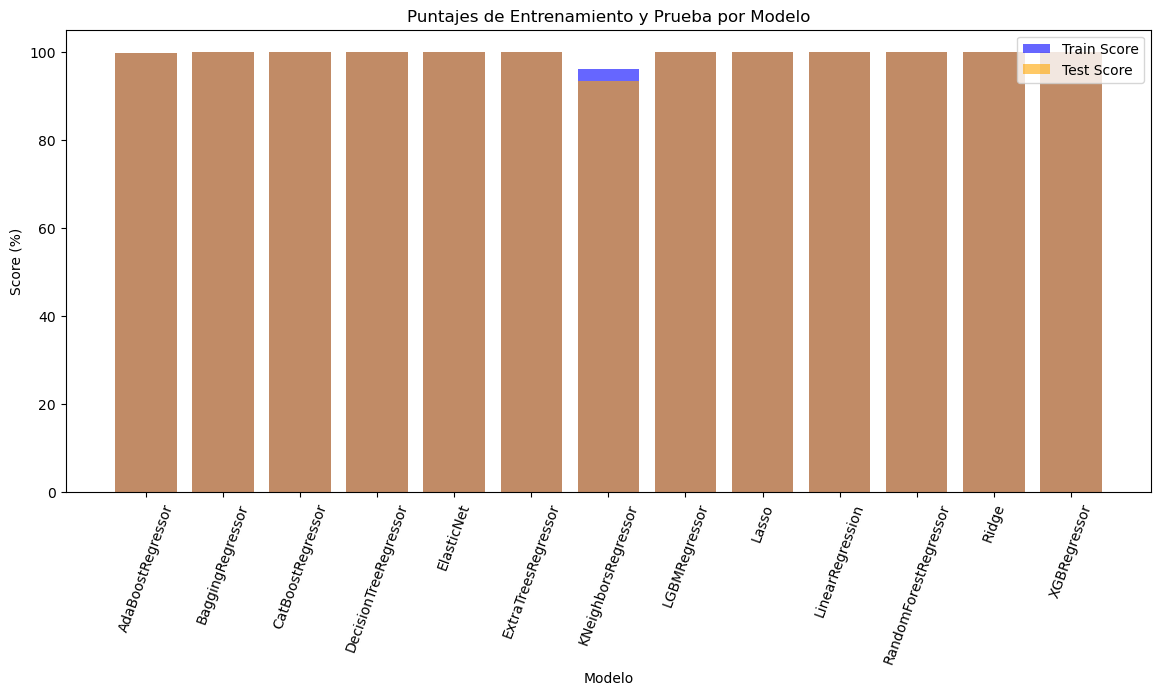

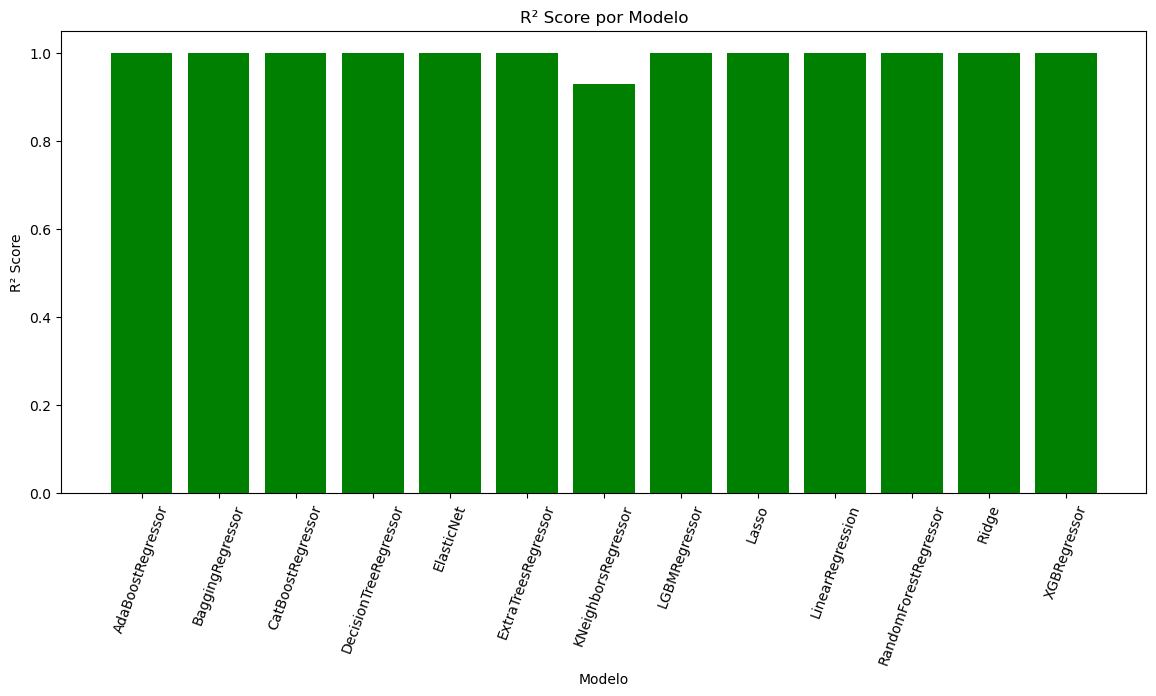

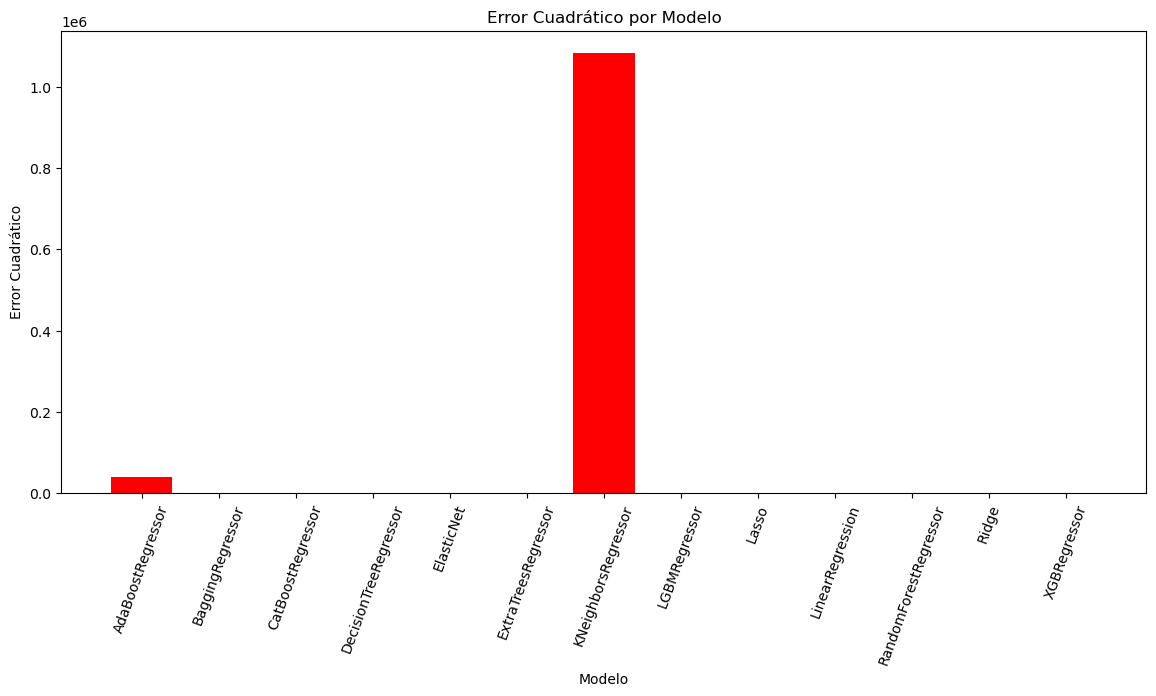

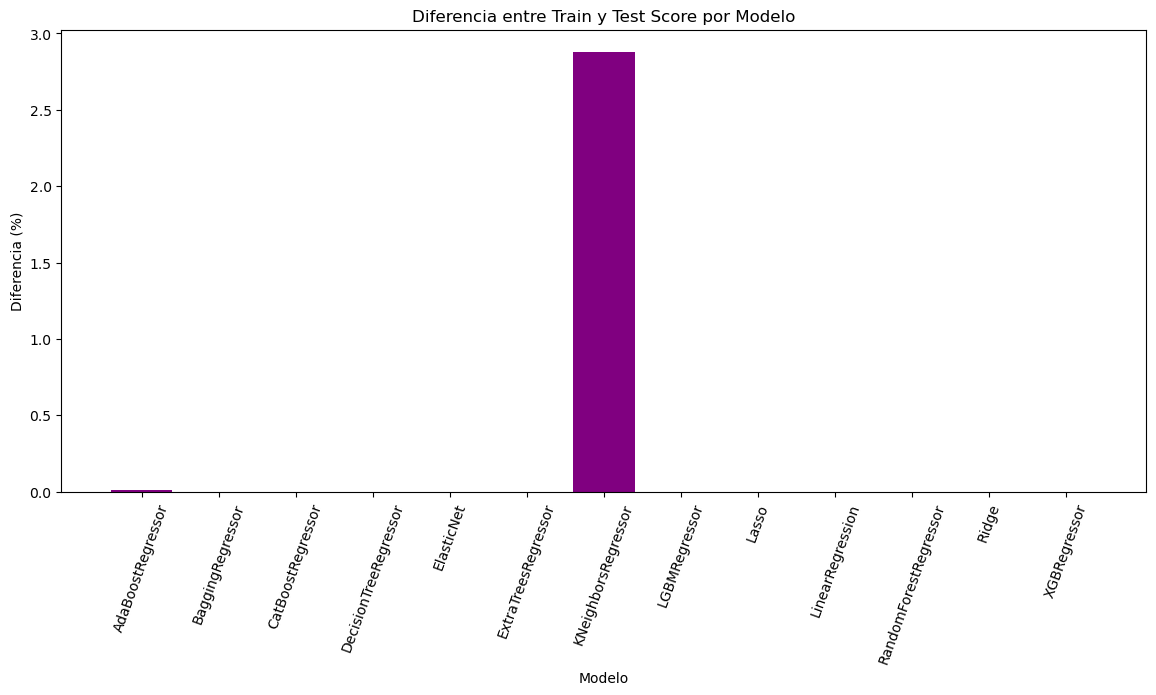

In [51]:
# Gráfica de Barras de los Puntajes de Entrenamiento y Prueba
plt.figure(figsize=(14, 6))
plt.bar(model_score['Modelo'], model_score['Train score'].str.rstrip('%').astype(float), color='blue', alpha=0.6, label='Train Score')
plt.bar(model_score['Modelo'], model_score['Test score'].str.rstrip('%').astype(float), color='orange', alpha=0.6, label='Test Score')
plt.xticks(rotation=70)
plt.title('Puntajes de Entrenamiento y Prueba por Modelo')
plt.xlabel('Modelo')
plt.ylabel('Score (%)')
plt.legend()
plt.show()

# Gráfica de R² Score
plt.figure(figsize=(14, 6))
plt.bar(model_score['Modelo'], model_score['R² score'].astype(float), color='green')
plt.xticks(rotation=70)
plt.title('R² Score por Modelo')
plt.xlabel('Modelo')
plt.ylabel('R² Score')
plt.show()

# Gráfica de Errores Cuadráticos (Squared Error)
plt.figure(figsize=(14, 6))
plt.bar(model_score['Modelo'], model_score['Squared error'].str.rstrip('%').astype(float), color='red')
plt.xticks(rotation=70)
plt.title('Error Cuadrático por Modelo')
plt.xlabel('Modelo')
plt.ylabel('Error Cuadrático')
plt.show()

# Gráfica de Diferencia entre Train y Test Score
plt.figure(figsize=(14, 6))
train_test_diff = model_score['Train score'].str.rstrip('%').astype(float) - model_score['Test score'].str.rstrip('%').astype(float)
plt.bar(model_score['Modelo'], train_test_diff, color='purple')
plt.xticks(rotation=70)
plt.title('Diferencia entre Train y Test Score por Modelo')
plt.xlabel('Modelo')
plt.ylabel('Diferencia (%)')
plt.show()
